# Deep Learning Models with GloVe Word embeddings

Generally, all the following models use **stop word removal** and **GloVe embeddings**, with a max token length of 10000 (just following the tutorial below, a bit arbitrary). This is input as an `Embedding` layer in Keras

For LSTM/Bi-LSTM, refer to Option 5 for best performing models.

In [65]:
# Following: https://medium.com/analytics-vidhya/multiclass-text-classification-using-deep-learning-f25b4b1010e5

import re
import tqdm
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [66]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [67]:
def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

In [4]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
# load test set
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  48854 non-null  int64 
 1   text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


In [5]:
# set constants
MAX_NB_WORDS = 100000 # max number of words for tokenizer TODO: double check with this dataset
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding TODO: double check for this dataset supposed to be 131926
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 300 # embedding dimensions for word vectors
GLOVE_DIR = f"glove/glove.6B.{EMBEDDING_DIM}d.txt"


In [6]:
# find the max number of tokens in a single row: answer = 131926 
# Don't run if not needed
recalculate = False
if recalculate: 
    maxLen = 0
    for sentence in x: 
        tokens = nltk.word_tokenize(sentence)
        maxLen = max(maxLen, len(tokens))
    print(maxLen)

In [7]:
# sentence cleaning
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
    text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
    text = str(text).replace(r'\.',' . ') # replace periods with a single one
    text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
    text = str(text).replace("\n", "") #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts
    if remove_stopwords:
        text = text.split(" ")

    for word in text:
        if word not in stopwords.words("english"):
            output = f"{output} {word}"
    return output.strip()

In [8]:
# remove stopwords from x

import os 
# check if "texts_cleaned.csv" exists
if not os.path.exists("texts_cleaned.csv"):
    texts = []
    counter = 0
    
    print(f"total of {len(x)} lines")
    output = pd.DataFrame()
    for line in x: 
        texts.append(clean_text(line))

        if len(texts) % 100 == 0: 
            counter += 100
            print(f"cleaned {counter} lines")
            
            temp_df = pd.DataFrame({"texts": texts})
            # concat with output dataframe
            output = pd.concat([output, temp_df], ignore_index=True)
            texts = []

    output.to_csv("texts_cleaned.csv", index=False)

clean_text_df = pd.read_csv("texts_cleaned.csv")
texts = clean_text_df["texts"]
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
texts


0        little less decade ago hockey fans blessed sla...
1        writers hbo series sopranos took another darin...
2        despite claims tv news outlet offer nonstop ne...
3        receiving subpar service experiencing unusuall...
4        watching beloved seattle mariners prevail san ...
                               ...                        
48795    president yingjeou assured paraguay tuesday mo...
48796    taiwan may file complaint world trade organiza...
48797    20 legislators opposition democratic progressi...
48798    taiwan may file complaint world trade organiza...
48799    taiwan confederation trade unions tctu said th...
Name: texts, Length: 48800, dtype: object

In [9]:
# split into X_test and y_test
X_test = test_df['cleaned_text']

# transform y_test into one hot vectors
y_test = pd.get_dummies(test_df["labels"])
y_test = np.array(y_test)

# transform y into one hot vectors
y = pd.get_dummies(df["labels"])
y = np.array(y)
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [10]:
# tokenize train
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

# tokenize test
print("START tokenize test")
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
test_tokenizer.fit_on_texts(X_test)
test_sequences = test_tokenizer.texts_to_sequences(X_test)
test_word_index = test_tokenizer.word_index
print("DONE tokenize test")


Vocabulary size: 323792
START tokenize test
DONE tokenize test


In [11]:
# pad data so they are uniform
X_test = pad_sequences(test_sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print(f"Shape of train data tensor: {data.shape}")
print(f"Shape of train label tensor: {y.shape}")
print(f"Shape of test data tensor: {X_test.shape}")
print(f"Shape of test label tensor: {y_test.shape}")

Shape of train data tensor: (48800, 1000)
Shape of train label tensor: (48854, 4)
Shape of test data tensor: (3000, 1000)
Shape of test label tensor: (3000, 4)


In [12]:
# shuffle train data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]


In [13]:
# split train data
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
X_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
X_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print("Number of entries in each category:")
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [11304  5563 14174  7999]
validation:  [2743 1379 3696 1942]


In [14]:
# create embedding matrix
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print(f"Loading Glove from: {GLOVE_DIR}")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove/glove.6B.300d.txt
Done.
 Proceeding with Embedding Matrix...
Completed!


In [40]:
# def load_glove(word_index):
#     def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:EMBEDDING_DIM]
#     embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(GLOVE_DIR))
#     all_embs = np.stack(embeddings_index.values())
#     emb_mean,emb_std = -0.005838499,0.48782197
#     embed_size = all_embs.shape[1]
#     nb_words = min(MAX_NB_WORDS, len(word_index)+1)
#     embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
#     for word, i in word_index.items():
#         if i >= MAX_NB_WORDS: continue
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector
#         else:
#             embedding_vector = embeddings_index.get(word.capitalize())
#             if embedding_vector is not None:
#                 embedding_matrix[i] = embedding_vector
#     return embedding_matrix
# embedding_matrix = load_glove(tokenizer.word_index)

/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# class Embeddings():
#     """
#     A class to read the word embedding file and to create the word embedding matrix
#     """

#     def __init__(self, path, vector_dimension):
#         self.path = path 
#         self.vector_dimension = vector_dimension
    
#     @staticmethod
#     def get_coefs(word, *arr): 
#         return word, np.asarray(arr, dtype='float32')

#     def get_embedding_index(self):
#         embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
#         return embeddings_index

#     def create_embedding_matrix(self, tokenizer, max_features):
#         """
#         A method to create the embedding matrix
#         """
#         model_embed = self.get_embedding_index()

#         embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
#         for word, index in tokenizer.word_index.items():
#             if index > max_features:
#                 break
#             else:
#                 try:
#                     embedding_matrix[index] = model_embed[word]
#                 except:
#                     continue
#         return embedding_matrix

# Option 1: Basic Neural Network (Not working)

In [58]:
# following tutorial: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
    model.add(Embedding(len(word_index) + 1,
        EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQUENCE_LENGTH,
        trainable=False,
        name = 'embeddings'))
    model.add(GlobalMaxPool1D()) # TODO CHECK
    model.add(Dense(8, input_dim=MAX_SEQUENCE_LENGTH, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
         "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ])
    return model
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

/var/folders/68/c2vd8ndn12s0ky3brj493wzr0000gn/T/ipykernel_28933/3687624663.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)


In [59]:
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring=tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro"))
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

# Option 2: CNN (Working)

Uses GloVe embeddings as loaded above.

In [15]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics = [
        "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ]
)
model.summary()

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-02 10:23:30.713079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 10:23:30.713338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         97137900  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                        

In [17]:
history = model.fit(X_train, y_train, epochs = 2, batch_size=10, validation_data=[X_val, y_val])

Epoch 1/2
3904/3904 [==============================] - ETA: 0s - loss: 0.1607 - categorical_accuracy: 0.9451 - precision: 0.9541 - recall: 0.9376 - auc: 0.9947 - f1_score_micro: 0.9451 - f1_score_macro: 0.9407

2023-04-02 10:35:34.208751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3904/3904 [==============================] - 702s 180ms/step - loss: 0.1607 - categorical_accuracy: 0.9451 - precision: 0.9541 - recall: 0.9376 - auc: 0.9947 - f1_score_micro: 0.9451 - f1_score_macro: 0.9407 - val_loss: 0.1003 - val_categorical_accuracy: 0.9649 - val_precision: 0.9688 - val_recall: 0.9620 - val_auc: 0.9979 - val_f1_score_micro: 0.9649 - val_f1_score_macro: 0.9619
Epoch 2/2
3904/3904 [==============================] - 651s 167ms/step - loss: 0.0190 - categorical_accuracy: 0.9942 - precision: 0.9946 - recall: 0.9939 - auc: 0.9997 - f1_score_micro: 0.9942 - f1_score_macro: 0.9936 - val_loss: 0.1222 - val_categorical_accuracy: 0.9625 - val_precision: 0.9636 - val_recall: 0.9609 - val_auc: 0.9959 - val_f1_score_micro: 0.9625 - val_f1_score_macro: 0.9595


In [18]:
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


INFO:tensorflow:Assets written to: cnn_model/assets


In [19]:
results = model.evaluate(X_val, y_val, batch_size=10)
print('Test loss:', results[0])
print('Test categorical_accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])
print('Test auc:', results[4])
print('Test F1 (micro):', results[5])
print('Test F1 (macro):', results[6])

976/976 [==============================] - 29s 29ms/step - loss: 0.1222 - categorical_accuracy: 0.9625 - precision: 0.9636 - recall: 0.9609 - auc: 0.9959 - f1_score_micro: 0.9625 - f1_score_macro: 0.9595
Test loss: 0.12224296480417252
Test categorical_accuracy: 0.9624999761581421
Test precision: 0.9636251330375671
Test recall: 0.9608606696128845
Test auc: 0.9959207773208618
Test F1 (micro): 0.9624999761581421
Test F1 (macro): 0.959509015083313


START predict
 1/94 [..............................] - ETA: 20s

2023-04-02 10:51:46.178287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 2s 15ms/step
DONE predict
START evaluate


2023-04-02 10:51:48.066956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 6s 47ms/step - loss: 3.4147 - categorical_accuracy: 0.3420 - precision: 0.3492 - recall: 0.3333 - auc: 0.5999 - f1_score_micro: 0.3420 - f1_score_macro: 0.3184
Test loss: 3.414722204208374
Test categorical_accuracy: 0.34200000762939453
Test precision: 0.3491620421409607
Test recall: 0.3333333432674408
Test auc: 0.5998998284339905
Test F1 (micro): 0.34200000762939453
Test F1 (macro): 0.3184450566768646


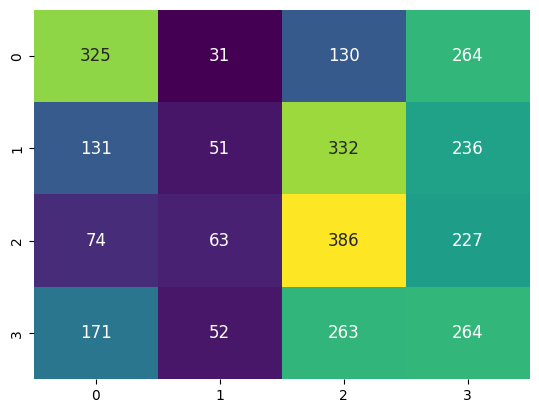

In [20]:
# predict test
print("START predict")
test_predictions = model.predict(X_test)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(X_test, y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(y_test, axis=1), test_result)

# Option 3: LSTM (Working, but unused)
NOTE: This has been superceded by `lstm-bilstm_classifier.ipynb`

In [ ]:
# create model
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable=False,
    name = 'embeddings'))
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 1000, 300)         97137900  
                                                                 
 lstm_layer (LSTM)           (None, 1000, 60)          86640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_50 (Dense)            (None, 50)                3050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                     

In [ ]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics = [
        "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ]
)

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10


2023-03-29 14:22:16.164936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:22:16.999492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:22:22.642972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - ETA: 0s - loss: 0.5223 - categorical_accuracy: 0.8067 - precision_3: 0.8972 - recall_3: 0.7078 - auc_1: 0.9558 - f1_score_micro: 0.8067 - f1_score_macro: 0.7904

2023-03-29 14:25:00.884492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 14:25:01.090791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 193s 554ms/step - loss: 0.5223 - categorical_accuracy: 0.8067 - precision_3: 0.8972 - recall_3: 0.7078 - auc_1: 0.9558 - f1_score_micro: 0.8067 - f1_score_macro: 0.7904 - val_loss: 0.2149 - val_categorical_accuracy: 0.9253 - val_precision_3: 0.9384 - val_recall_3: 0.9159 - val_auc_1: 0.9916 - val_f1_score_micro: 0.9253 - val_f1_score_macro: 0.9191
Epoch 2/10
305/305 [==============================] - 162s 529ms/step - loss: 0.1941 - categorical_accuracy: 0.9332 - precision_3: 0.9422 - recall_3: 0.9248 - auc_1: 0.9930 - f1_score_micro: 0.9332 - f1_score_macro: 0.9272 - val_loss: 0.1599 - val_categorical_accuracy: 0.9452 - val_precision_3: 0.9525 - val_recall_3: 0.9382 - val_auc_1: 0.9949 - val_f1_score_micro: 0.9452 - val_f1_score_macro: 0.9404
Epoch 3/10
305/305 [==============================] - 162s 530ms/step - loss: 0.1306 - categorical_accuracy: 0.9546 - precision_3: 0.9597 - recall_3: 0.9497 - auc_1: 0.9966 - f1_score_micro: 0.9546 - f1_

In [118]:
model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


In [ ]:
results = model.evaluate(X_val, y_val, batch_size=128)
print('Test loss:', results[0])
print('Test categorical_accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])
print('Test auc:', results[4])
print('Test F1 (micro):', results[5])
print('Test F1 (macro):', results[6])

77/77 [==============================] - 18s 233ms/step - loss: 0.1064 - categorical_accuracy: 0.9701 - precision_3: 0.9706 - recall_3: 0.9693 - auc_1: 0.9961 - f1_score_micro: 0.9701 - f1_score_macro: 0.9681
Test loss: 0.10643189400434494
Test categorical_accuracy: 0.9700819849967957
Test precision: 0.9705550670623779
Test recall: 0.9692623019218445
Test auc: 0.9960734844207764
Test F1 (micro): 0.9700820446014404
Test F1 (macro): 0.9680694341659546


START predict
94/94 [==============================] - 20s 208ms/step
DONE predict
START evaluate
94/94 [==============================] - 25s 264ms/step - loss: 5.1981 - categorical_accuracy: 0.3357 - precision_3: 0.3377 - recall_3: 0.3300 - auc_1: 0.5816 - f1_score_micro: 0.3357 - f1_score_macro: 0.3201
Test loss: 5.198129653930664
Test categorical_accuracy: 0.3356666564941406
Test precision: 0.3376534879207611
Test recall: 0.32999998331069946
Test auc: 0.5815756320953369
Test F1 (micro): 0.3356666564941406
Test F1 (macro): 0.320085346698761


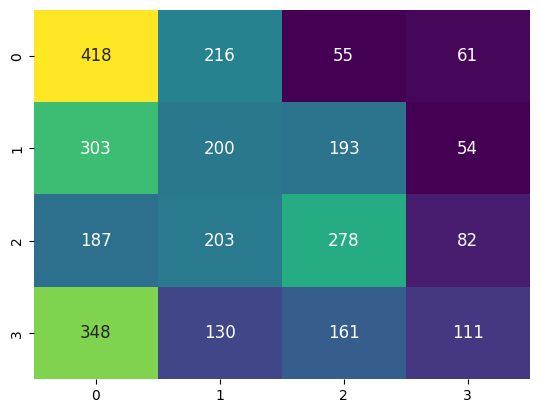

In [ ]:
# predict
print("START predict")
test_predictions = model.predict(X_test)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(X_test, y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(y_test, axis=1), test_result)

# Option 3: Bi-LSTM (Working, but not in use)
NOTE: This has been superceded by `lstm-bilstm_classifier.ipynb`

In [15]:
# create model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable=False,
    name = 'embeddings'))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-02 17:59:26.567639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 17:59:26.567758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 1000, 300)         97137900  
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 512)        1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              795600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                6

In [16]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics = [
        "categorical_accuracy", 
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ]
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/10


2023-04-02 17:59:27.589257: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 17:59:29.940495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:59:30.572443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:59:30.592200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:59:36.466556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:59:36.535524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:59:42.456743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

305/305 [==============================] - ETA: 0s - loss: 0.4820 - categorical_accuracy: 0.8232 - precision: 0.8714 - recall: 0.7789 - auc: 0.9598 - f1_score_micro: 0.8232 - f1_score_macro: 0.8116

2023-04-02 18:23:57.634973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 18:23:57.967552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 18:23:58.055536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 18:24:04.406987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 18:24:04.498745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 1548s 5s/step - loss: 0.4820 - categorical_accuracy: 0.8232 - precision: 0.8714 - recall: 0.7789 - auc: 0.9598 - f1_score_micro: 0.8232 - f1_score_macro: 0.8116 - val_loss: 0.3622 - val_categorical_accuracy: 0.8735 - val_precision: 0.8918 - val_recall: 0.8564 - val_auc: 0.9764 - val_f1_score_micro: 0.8735 - val_f1_score_macro: 0.8675
Epoch 2/10
305/305 [==============================] - 1533s 5s/step - loss: 0.2623 - categorical_accuracy: 0.9080 - precision: 0.9226 - recall: 0.8947 - auc: 0.9869 - f1_score_micro: 0.9080 - f1_score_macro: 0.9015 - val_loss: 0.2224 - val_categorical_accuracy: 0.9242 - val_precision: 0.9365 - val_recall: 0.9136 - val_auc: 0.9902 - val_f1_score_micro: 0.9242 - val_f1_score_macro: 0.9181
Epoch 3/10
305/305 [==============================] - 1444s 5s/step - loss: 0.1702 - categorical_accuracy: 0.9417 - precision: 0.9494 - recall: 0.9339 - auc: 0.9940 - f1_score_micro: 0.9417 - f1_score_macro: 0.9378 - val_loss: 0.17

In [18]:
model.save('bi-lstm_model')

INFO:tensorflow:Assets written to: bi-lstm_model/assets


INFO:tensorflow:Assets written to: bi-lstm_model/assets


In [23]:
results = model.evaluate(X_val, y_val, batch_size=128)
print('Eval loss:', results[0])
print('Eval categorical_accuracy:', results[1])
print('Eval precision:', results[2])
print('Eval recall:', results[3])
print('Eval auc:', results[4])
print('Eval F1 (micro):', results[5])
print('Eval F1 (macro):', results[6])

77/77 [==============================] - 60s 759ms/step - loss: 0.1648 - categorical_accuracy: 0.9535 - precision: 0.9550 - recall: 0.9525 - auc: 0.9927 - f1_score_micro: 0.9535 - f1_score_macro: 0.9499
Eval loss: 0.1648164838552475
Eval categorical_accuracy: 0.9534835815429688
Eval precision: 0.9550031423568726
Eval recall: 0.9524590373039246
Eval auc: 0.9926600456237793
Eval F1 (micro): 0.9534836411476135
Eval F1 (macro): 0.9499143362045288


START predict
94/94 [==============================] - 63s 660ms/step
DONE predict
START evaluate
94/94 [==============================] - 64s 670ms/step - loss: 4.2114 - categorical_accuracy: 0.3977 - precision: 0.3992 - recall: 0.3967 - auc: 0.6337 - f1_score_micro: 0.3977 - f1_score_macro: 0.3567
Test loss: 4.211350917816162
Test categorical_accuracy: 0.39766666293144226
Test precision: 0.3991949260234833
Test recall: 0.39666667580604553
Test auc: 0.6337157487869263
Test F1 (micro): 0.39766669273376465
Test F1 (macro): 0.35672515630722046


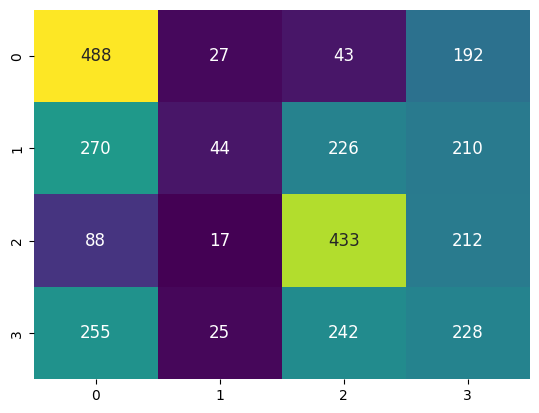

In [22]:
# predict
print("START predict")
test_predictions = model.predict(X_test)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(X_test, y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(y_test, axis=1), test_result)

# Option 5: Retry LSTM/Bi-LSTM
NOTE: Same as what you will find in `lstm-bilstm_classifier.ipynb`

In [73]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import tensorflow_addons as tfa
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [74]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
# load test set
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  48854 non-null  int64 
 1   text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


<Axes: ylabel='Frequency'>

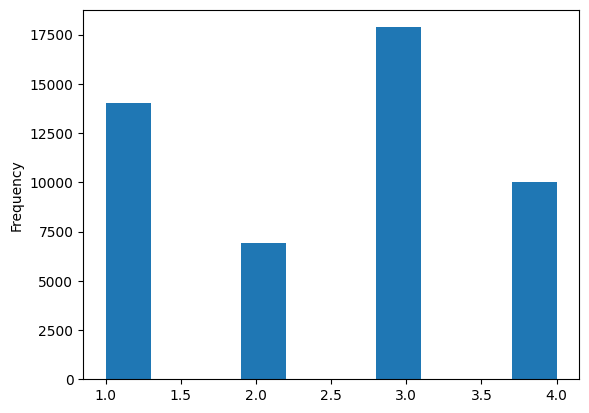

In [75]:
df["labels"].plot(kind="hist")

In [71]:
# Clean text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['text'] = df['text'].apply(clean_text)


In [76]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

GLOVE_DIR = f"glove/glove.6B.{EMBEDDING_DIM}d.txt"


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 259286 unique tokens.


In [77]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_test = tokenizer.texts_to_sequences(test_df['text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

Shape of data tensor: (48854, 250)
Shape of test data tensor: (3000, 250)


In [78]:
Y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', Y.shape)

Y_test = pd.get_dummies(test_df['labels']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (48854, 4)
Shape of label tensor: (3000, 4)


In [79]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(43968, 250) (43968, 4)
(4886, 250) (4886, 4)


In [80]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros= ros.fit_resample(X_train, Y_train)
# Check the number of records after over sampling
print('training: ', Y_train.sum(axis=0))
print('training ros: ', Y_train_ros.sum(axis=0))

training:  [12671  6244 16085  8968]
training ros:  [16085 16085 16085 16085]


In [81]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus= rus.fit_resample(X_train, Y_train)
# Check the number of records after under sampling
print('training: ', Y_train.sum(axis=0))
print('training rus: ', Y_train_rus.sum(axis=0))

training:  [12671  6244 16085  8968]
training rus:  [6244 6244 6244 6244]


In [82]:
# Under sample the majority class
nearmiss = NearMiss(version=3)
X_train_nearmiss, Y_train_nearmiss= nearmiss.fit_resample(X_train, Y_train)
# Check the number of records after over sampling
print('training: ', Y_train.sum(axis=0))
print('training nearmiss: ', Y_train_nearmiss.sum(axis=0))

/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


training:  [12671  6244 16085  8968]
training nearmiss:  [2339 6244 4098 1703]


/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [83]:
# create embedding matrix
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print(f"Loading Glove from: {GLOVE_DIR}")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove/glove.6B.100d.txt
Done.
 Proceeding with Embedding Matrix...
Completed!


In [84]:
use_glove = True # True for GloVe, False for Keras Tokenizer
use_bi_lstm = True # True for Bi-LSTM, False for LSTM

model = Sequential() 
if use_glove: 
    model.add(Embedding(len(tokenizer.word_index) + 1,
        EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQUENCE_LENGTH,
        trainable=False,
        name = 'embeddings'))
else: 
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) 
model.add(SpatialDropout1D(0.2))
if use_bi_lstm: 
    model.add(Bidirectional(LSTM(100))),
else: 
    model.add(LSTM(100, dropout=0.2))
model.add(Dense(100, activation='relu')),
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    "categorical_accuracy", 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall(), 
    tf.keras.metrics.AUC(),
    tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
    tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 250, 100)          25928700  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                

In [96]:
epochs = 5
batch_size = 64

history = model.fit(X_train_nearmiss, Y_train_nearmiss, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_f1_score_macro', patience=3, min_delta=0.0001)])

Epoch 1/5
203/203 [==============================] - 30s 147ms/step - loss: 0.0712 - categorical_accuracy: 0.9750 - precision_3: 0.9782 - recall_3: 0.9727 - auc_3: 0.9986 - f1_score_micro: 0.9750 - f1_score_macro: 0.9441 - val_loss: 2.3890 - val_categorical_accuracy: 0.5129 - val_precision_3: 0.5192 - val_recall_3: 0.5073 - val_auc_3: 0.7479 - val_f1_score_micro: 0.5129 - val_f1_score_macro: 0.1695
Epoch 2/5
203/203 [==============================] - 29s 144ms/step - loss: 0.0649 - categorical_accuracy: 0.9771 - precision_3: 0.9797 - recall_3: 0.9746 - auc_3: 0.9989 - f1_score_micro: 0.9771 - f1_score_macro: 0.9515 - val_loss: 2.2625 - val_categorical_accuracy: 0.5149 - val_precision_3: 0.5201 - val_recall_3: 0.5038 - val_auc_3: 0.7329 - val_f1_score_micro: 0.5149 - val_f1_score_macro: 0.1700
Epoch 3/5
203/203 [==============================] - 32s 157ms/step - loss: 0.0624 - categorical_accuracy: 0.9792 - precision_3: 0.9809 - recall_3: 0.9778 - auc_3: 0.9990 - f1_score_micro: 0.9792 

In [97]:
results = model.evaluate(X_val, Y_val, batch_size=64)
print('Eval loss:', results[0])
print('Eval categorical_accuracy:', results[1])
print('Eval precision:', results[2])
print('Eval recall:', results[3])
print('Eval auc:', results[4])
print('Eval F1 (micro):', results[5])
print('Eval F1 (macro):', results[6])

77/77 [==============================] - 7s 89ms/step - loss: 0.4577 - categorical_accuracy: 0.8749 - precision_3: 0.8801 - recall_3: 0.8711 - auc_3: 0.9709 - f1_score_micro: 0.8749 - f1_score_macro: 0.8582
Eval loss: 0.45769357681274414
Eval categorical_accuracy: 0.8749488592147827
Eval precision: 0.8800661563873291
Eval recall: 0.8710601925849915
Eval auc: 0.9708582162857056
Eval F1 (micro): 0.8749489188194275
Eval F1 (macro): 0.8581573963165283


START predict
94/94 [==============================] - 7s 68ms/step
DONE predict
START evaluate
94/94 [==============================] - 8s 85ms/step - loss: 1.7922 - categorical_accuracy: 0.5930 - precision_3: 0.6004 - recall_3: 0.5790 - auc_3: 0.8044 - f1_score_micro: 0.5930 - f1_score_macro: 0.5942
Test loss: 1.7922228574752808
Test categorical_accuracy: 0.5929999947547913
Test precision: 0.6004148125648499
Test recall: 0.5789999961853027
Test auc: 0.8043859601020813
Test F1 (micro): 0.5929999947547913
Test F1 (macro): 0.5942159295082092


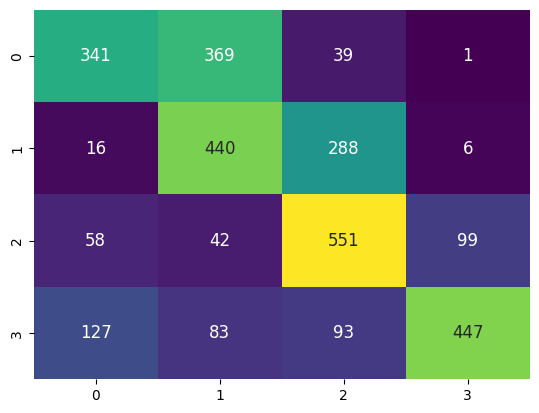

In [99]:
# predict
print("START predict")
test_predictions = model.predict(X_test)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(X_test, Y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(Y_test, axis=1), test_result)

In [100]:
model.save("bi-lstm_model_best")

INFO:tensorflow:Assets written to: bi-lstm_model_best/assets


INFO:tensorflow:Assets written to: bi-lstm_model_best/assets
